In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
import pickle
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

In [4]:
# Load the data and create a copy to use to verify preprocessing steps
quicken_df = pd.read_csv('data/wells_fargo.csv')
check_df = quicken_df.copy()
# Pull Census Tract dictionary from different notebook
%store -r FIPS_dict

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (43,46,77,78,79,80) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Initialize dictionary to store bank information
dict_keys = ['Lender', 'Likelihood of Approval', 'Certainty of Prediction', 'Approval Threshold', 'Black applicant error rate', 
                                         'Asian applicant error rate', 'Hispanic applicant error rate', 
                                         'Female applicant error rate']
wells_dict={}
wells_dict['Lender'] = 'Wells Fargo'


# Step 1: Drop Perfect Predictors, Census added columns, irrelevant columns

In [6]:
confirmed_perfect_pred = ['denial_reason-1', 'denial_reason-2', 'denial_reason-3', 'purchaser_type', 'preapproval', 
                       'interest_rate', 'rate_spread', 'hoepa_status', 'total_loan_costs', 'origination_charges', 
                       'discount_points', 'lender_credits', 'initially_payable_to_institution', 'denial_reason-4',
                        'total_points_and_fees']
quicken_df = quicken_df.drop(confirmed_perfect_pred, axis=1)

In [7]:
census_appended = ['tract_minority_population_percent', 'tract_population', 'ffiec_msa_md_median_family_income',
                  'tract_to_msa_income_percentage', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes',
                  'tract_median_age_of_housing_units']
quicken_df = quicken_df.drop(census_appended, axis=1)

In [8]:
drop_irrelevant = ['state_code', 'county_code', 'open-end_line_of_credit', 'manufactured_home_land_property_interest', 
                  'manufactured_home_secured_property_type', 'co-applicant_credit_score_type', 'applicant_ethnicity-2',
                  'applicant_ethnicity-3', 'applicant_ethnicity-4', 'co-applicant_ethnicity-1', 'co-applicant_ethnicity-2',
                  'co-applicant_ethnicity-3', 'co-applicant_ethnicity-4', 'co-applicant_ethnicity_observed',
                  'applicant_race-2', 'applicant_race-3', 'applicant_race-4', 'applicant_race-5', 
                  'co-applicant_race-1', 'co-applicant_race-2', 'co-applicant_race-3', 'co-applicant_race-4', 
                  'co-applicant_race-5', 'co-applicant_race_observed', 'co-applicant_sex', 'applicant_sex_observed',
                  'co-applicant_sex_observed', 'co-applicant_age', 'applicant_age_above_62', 'co-applicant_age_above_62',
                  'submission_of_application', 'derived_loan_product_type', 'interest_only_payment', 'applicant_ethnicity-1',
                  'applicant_race-1', 'applicant_sex', 'derived_msa-md', 'applicant_ethnicity-5', 
                  'co-applicant_ethnicity-5', 'activity_year', 'lei', 'multifamily_affordable_units', 
                  'aus-2', 'aus-3', 'aus-4', 'aus-5']
quicken_df = quicken_df.drop(drop_irrelevant, axis=1)

In [9]:
# drop features that would be difficult or impossible to gather from user input
drop_impossible = ['negative_amortization', 'balloon_payment', 'applicant_ethnicity_observed', 
                   'applicant_race_observed', 'aus-1', 'other_nonamortizing_features', 'applicant_credit_score_type',
                  'intro_rate_period']
quicken_df = quicken_df.drop(drop_impossible, axis=1)

# Step 2: Condense High Cardinality Columns

In [10]:
# action taken
quicken_df = quicken_df[~quicken_df['action_taken'].isin([4,5,7,8])]
quicken_df['action_taken'] = quicken_df['action_taken'].map(lambda x: 0 if x ==3 else 1)

# Step 3: Select loans that meet the following criteria, then drop those variables
* Loan Purpose: Home purchase (no refi, home improvement, etc)
* Lien Status: 1st liens only
* Reverse Mortgage: exclude
* Business/commercial: exclude
* Only principal, single family homes

In [11]:
quicken_df = quicken_df[quicken_df['loan_purpose'] == 1]
quicken_df = quicken_df[quicken_df['lien_status'] == 1]
quicken_df = quicken_df[quicken_df['reverse_mortgage'] == 2]
quicken_df = quicken_df[quicken_df['business_or_commercial_purpose'] == 2]
quicken_df = quicken_df[(quicken_df['total_units'] == '1') | (quicken_df['total_units'] == 1)]
quicken_df = quicken_df[quicken_df['occupancy_type'] == 1]

In [12]:
drop_after_subselection = ['loan_purpose', 'lien_status', 'reverse_mortgage', 'business_or_commercial_purpose', 
                          'total_units', 'occupancy_type']
quicken_df = quicken_df.drop(drop_after_subselection, axis=1)

# Step 4: Ensure all null values are coded the same way, or drop if very few nulls
* Applicant credit score type mostly null (9)

In [13]:
quicken_df = quicken_df[quicken_df['conforming_loan_limit'] != 'U']

In [14]:
age_na_lst = [8888, '8888', '9999', 9999]
quicken_df['applicant_age'] = quicken_df['applicant_age'].apply(lambda x: np.nan if x in age_na_lst else x)

# Step 5: Variable Encoding
* Dropped nan before encoding, or ignored
* DIR: Debt-to-income ratio
* Age (dropped 908 nan)
* Census Tract

In [15]:
DIR_mapper = {'20%-<30%': 25, '30%-<36%': 33, '>60%': 65, '<20%': 15, '50%-60%': 55}


quicken_df['debt_to_income_ratio'] = quicken_df['debt_to_income_ratio'] \
                                    .map(lambda x: DIR_mapper[x] if x in DIR_mapper else int(x), na_action='ignore')

In [16]:
quicken_df = quicken_df[quicken_df['applicant_age'].notnull()]

In [17]:
# Create ordinalencoder object for age column
enc = OrdinalEncoder()

# Convert column to array
age_df = quicken_df[['applicant_age']].to_numpy()
enc.fit(age_df)
enc.categories_

# fitted encoder to array
enc_age_arr = enc.transform(quicken_df[['applicant_age']].to_numpy())

# Apply encoder transformation
quicken_df['applicant_age'] = enc_age_arr

In [18]:
# Convert census tracts to one of ten categories (rural, urban, etc)
quicken_df = quicken_df.dropna(subset=['census_tract'])
quicken_df['census_tract'] = quicken_df['census_tract'].astype(int)
quicken_df['census_tract'] = quicken_df['census_tract'].astype(str)
quicken_df['census_tract'] = quicken_df['census_tract'].map(FIPS_dict)

# Step 5: Handle Missing Values
* Confirmed values MAR
* Drop applicant credit score type"
    * 70% null values, will drop column instead of dropping null rows
* Time crunch - dropped other missing value rows

In [19]:
# Impute median for nan in the following columns
quicken_df['debt_to_income_ratio'] = quicken_df['debt_to_income_ratio'].fillna(quicken_df['debt_to_income_ratio'] \
                                                                               .median())
quicken_df['income'] = quicken_df['income'].fillna(quicken_df['income'].median())
quicken_df['property_value'] = quicken_df['property_value'].fillna(quicken_df['property_value'].median())
quicken_df['income'] = quicken_df['income'].fillna(quicken_df['income'].median())
quicken_df['loan_to_value_ratio'] = quicken_df['loan_to_value_ratio'].fillna(quicken_df['loan_to_value_ratio'] \
                                                                             .median())

In [20]:
one_unique_value_lst = []
for col in quicken_df.columns:
    if len(quicken_df[col].unique()) ==1: 
        one_unique_value_lst.append(col)
quicken_df = quicken_df.drop(one_unique_value_lst, axis=1)


In [21]:
# If the percentage of NON null values is under 5% of the entire dataset, drop column
mostly_null = []
for col in quicken_df.columns: 
    if quicken_df[col].notnull().sum()/quicken_df.shape[0] * 100 <5:
        mostly_null.append(col)
quicken_df = quicken_df.drop(mostly_null, axis=1)


In [22]:
# create list of columns that have null values that need to be handled
has_nulls = []
for col in quicken_df.columns: 
    if quicken_df[col].notnull().sum() != quicken_df.shape[0]: 
        has_nulls.append(col)
has_nulls

['census_tract']

In [23]:
# Calculate missing value ratio for remaining columns with null value
missing_val_dict = {}
for col in has_nulls: 
    missing_val_dict[col] = quicken_df[col].isnull().sum()/quicken_df.shape[0]* 100
missing_val_dict

{'census_tract': 18.64405822314353}

In [24]:
quicken_df = quicken_df.dropna(subset=['census_tract'])

In [25]:
quicken_df = quicken_df[quicken_df['census_tract'] != 99]

#### Drop highly correlated columns
* property value & loan amount (0.97) - kept loan amount as this is more likely the value the app user will know

In [26]:
quicken_df = quicken_df.drop('property_value', axis=1)

# Model preparation

In [27]:
categorical_cols = ['census_tract', 'conforming_loan_limit', 'derived_dwelling_category', 'derived_ethnicity', 
                      'derived_race', 'derived_sex', 'loan_type', 'construction_method']

In [28]:
# feature (X) and target(y) matrices, will encode on X instead of entire dataframe
X = quicken_df.drop(['action_taken'], axis=1)
y = quicken_df['action_taken']

In [29]:
# Use one-hot encoding for categorical columns
X = pd.get_dummies(X, columns = categorical_cols)

In [30]:
# Drop columns that are duplicates of a binary dummy variable
dummies_to_drop = ['derived_sex_Female', 
                   'conforming_loan_limit_NC', 'construction_method_2', 
                   'derived_dwelling_category_Single Family (1-4 Units):Manufactured', 
                     'derived_ethnicity_Free Form Text Only', 
                   'derived_race_Free Form Text Only',
                   'derived_ethnicity_Not Hispanic or Latino']
X = X.drop(dummies_to_drop, axis=1)

In [32]:
# Create TTS on entire dataset, stratify y to handle class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state=42)

# Take subset to train model initially
X_sub = X[::10]
y_sub = y[::10]
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size = 0.20, 
                                                                    shuffle=True, stratify=y_sub)

In [181]:
sgd_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier(loss='log'))])
fitted = sgd_pipe.fit(X_train, y_train)
sgd_preds = fitted.predict(X_test)

In [182]:
sgd_probs = fitted.predict_proba(X_test)

In [183]:
sgd_mvp = pd.DataFrame(data=[accuracy_score(y_test, sgd_preds), recall_score(y_test, sgd_preds),
                   precision_score(y_test, sgd_preds), roc_auc_score(y_test, sgd_preds), 
                   f1_score(y_test, sgd_preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])

,0
accuracy,0.968254
recall,0.999401
precision,0.968404
roc_auc_score,0.645320
f1 score,0.983658


#### Tuning hyperparameters

In [184]:
sgd_pipe2 = Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier(loss='log', warm_start=True))])
sgd_grid_params = {'classifier__penalty' : ['l1','l2', 'elasticnet'], 'classifier__alpha' : np.logspace(-4, 4, 20)}
sgd_grid = GridSearchCV(sgd_pipe2, sgd_grid_params, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
sgd_fitted2 = sgd_grid.fit(X_train, y_train)
sgd_preds2 = sgd_fitted2.predict(X_test)

In [ ]:
sgd_probs2 = sgd_fitted2.predict_proba(X_test)
sgd_probs_sub = sgd_fitted2.predict_proba(X_test_sub)

In [186]:
# Store model performance in diction and pickle the model 
wells_dict['Certainty of Prediction'] = f1_score(y_test, sgd_preds2)

with open('wells_model2.pkl', 'wb') as f:
    pickle.dump(sgd_fitted2, f)

# Model Performance

In [185]:
sgd_tuned = pd.DataFrame(data=[accuracy_score(y_test, sgd_preds2), recall_score(y_test, sgd_preds2),
                   precision_score(y_test, sgd_preds2), roc_auc_score(y_test, sgd_preds2), 
                   f1_score(y_test, sgd_preds2)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])

,0
accuracy,0.968289
recall,0.998711
precision,0.969065
roc_auc_score,0.652868
f1 score,0.983665


Text(0, 0.5, 'True Positive Rate')

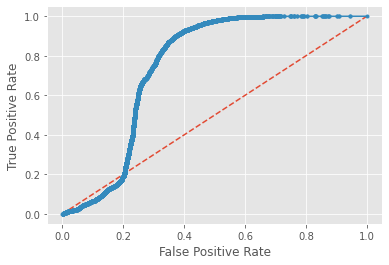

In [191]:
# keep probabilities for the positive outcome only
sgd_probs = sgd_probs[:, 1]

# calculate scores
sgd_auc = roc_auc_score(y_test, sgd_probs)
# roc curve for logistic regression model
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, sgd_probs)
fig, ax = plt.subplots()
# plot the roc curve for the model
ax.plot([0,1], [0,1], linestyle='--', label='No Skill')
ax.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')




# Feature Importance

In [188]:
best_sgdclassifier = sgd_grid.best_estimator_.named_steps['classifier']
coefs = best_sgdclassifier.coef_
coefs = coefs.flatten().tolist()
features = X_test.columns.tolist()
features_df = pd.DataFrame({'features': features, 'coefficients' : coefs}) \
                                            .sort_values(by='coefficients', ascending=False)

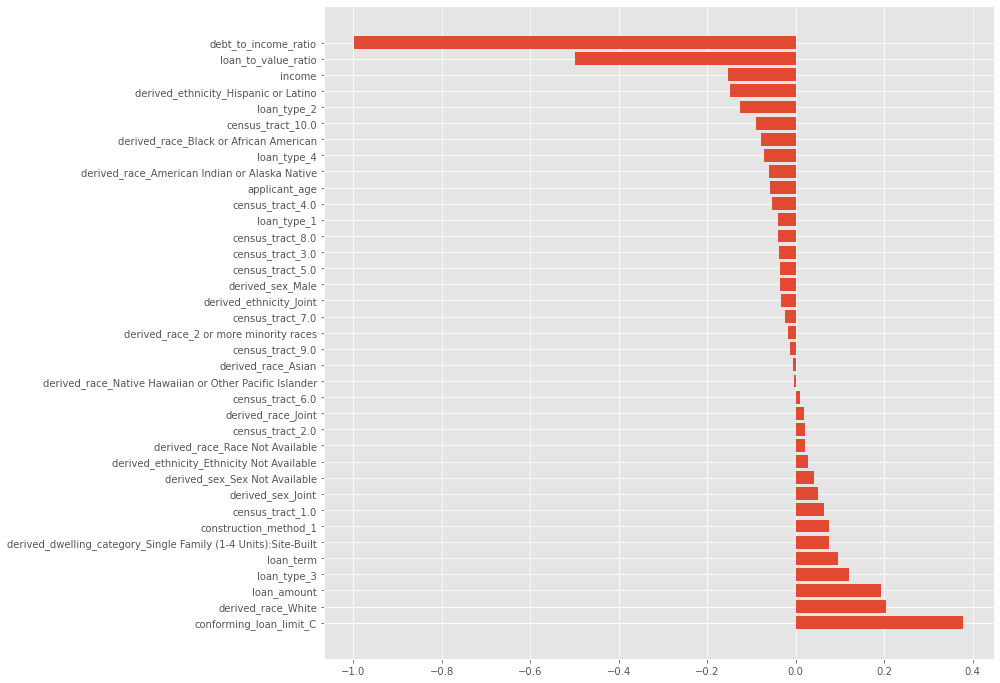

In [189]:
fig, ax = plt.subplots(figsize=(12,12))
ax.barh(features_df.features, width=features_df.coefficients);

In [190]:
data_tuples = list(zip(features,coefs))
wells_features = pd.DataFrame(data_tuples, columns=['features', 'coefs'])
%store wells_features

Stored 'wells_features' (DataFrame)


In [34]:
# TP benefit: loan sale
tp_profit = quicken_df['loan_amount'].mean()*0.01

# FP cost: potential to have to buy back the loan and lose street cred with investors - lower rates, etc
## this is rare because underwriters confirm information in the AUS
fp_cost = -tp_profit*1.005

# FN: opportunity cost * market share
fn_cost = -tp_profit*(0.0495)

tn = 0

# Create confusion matrix
cost_benefit_matrix = np.array([[tn, fp_cost],[fn_cost, tp_profit]])
cost_benefit_matrix

array([[    0.        , -3027.66812293],
       [ -149.12395232,  3012.60509744]])

In [36]:
def profit_curve(cost_benefit_matrix, y_prob, y_test):
    """ To calculate list of profits based on supplied cost-benefit
    matrix and predicted probabilities of data points and their true labels.

    Parameters
    ----------
    cost_benefit_matrix    : ndarray - 2D, with profit values corresponding to:
                                          -----------
                                          | TP | FP |
                                          -----------
                                          | FN | TN |
                                          -----------
    y_prob : ndarray - 1D, predicted probability for each data point
                                    in labels, in range [0, 1]
    y_test : ndarray - 1D, true label of data points, 0 or 1

    Returns
    -------
    profits    : ndarray - 1D
    thresholds : ndarray - 1D
    """
    n_obs = float(len(y_test))

  
    thresholds =  sorted(y_prob, reverse=True)
    profits = []
    y_preds = []
    for threshold in thresholds:

        y_pred = y_prob >= threshold
        confusion_mat = confusion_matrix(y_test, y_pred)
        profit = np.sum(cost_benefit_matrix*confusion_mat)/n_obs
        profits.append(profit)
    return np.array(profits), np.array(thresholds)

In [38]:
sgd_probs_sub= final_model.predict_proba(X_test_sub)
profits, thresholds = profit_curve(cost_benefit_matrix, sgd_probs_sub[:,1], y_test_sub)

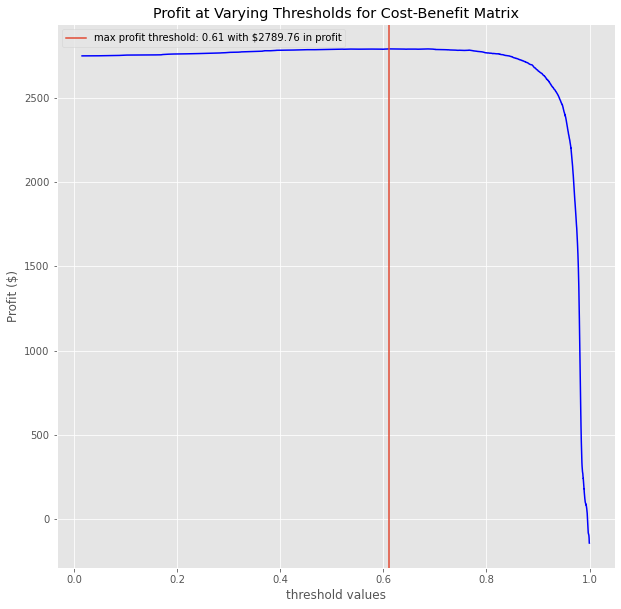

In [39]:
max_profit = np.max(np.array(profits))
max_profit_thresh = thresholds[np.argmax(np.array(profits))]
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(thresholds, profits, color='blue')
ax.set_xlabel('threshold values')
ax.set_ylabel('Profit ($)')
ax.axvline(max_profit_thresh, label=f'max profit threshold: {round(max_profit_thresh,2)} with ${round(max_profit, 2)} in profit')
ax.set_title('Profit at Varying Thresholds for Cost-Benefit Matrix')
ax.legend()
plt.savefig('BOA_profit_curve.png')

In [323]:
# Use threshold from Profit Curve to determine classification
final_preds = []
for i in sgd_probs_sub: 
    if i >=.95: 
        final_preds.append(1)
    else: 
        final_preds.append(0)

In [324]:
# Threshold @70%
thres_max = pd.DataFrame(data=[accuracy_score(y_test_sub, final_preds), recall_score(y_test_sub, final_preds),
                   precision_score(y_test_sub, final_preds), roc_auc_score(y_test_sub, final_preds), 
                   f1_score(y_test_sub, final_preds)], 
                     index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])
# Threshold @70%
baseline= pd.DataFrame(data=[accuracy_score(y_test, sgd_preds), recall_score(y_test, sgd_preds),
                   precision_score(y_test, sgd_preds), roc_auc_score(y_test, sgd_preds), 
                   f1_score(y_test, sgd_preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])


In [325]:
sgd_probs = final_model.predict(X_test)

In [326]:
baseline['new thresh'] = thres_max[0]
baseline

,0,new thresh
accuracy,0.968254,0.847328
recall,0.999401,0.860889
precision,0.968404,0.976053
roc_auc_score,0.645320,0.717209
f1 score,0.983658,0.914861


In [296]:
thres_80_

,0
accuracy,0.966690
recall,0.997087
precision,0.968861
roc_auc_score,0.675014
f1 score,0.982771


In [276]:
thres_50_

,0
accuracy,0.968289
recall,0.998711
precision,0.969065
roc_auc_score,0.652868
f1 score,0.983665


# Bias evaluation

### Start with baseline type I, type II error rates on existing dataset

In [145]:
# Create array of predicted values on entire test set
y_pred_baseline = fitted.predict(X_test)

# Make df of predictions with predicted and true columns to be used for comparison
base_analysis = X_test.copy() 
base_analysis['Pred Approval'] = y_pred_baseline
base_analysis['Actual Approval'] = y_test


# Create DFs with indices of black applicants and white applicants, respectively. Because I am pulling records
# by race, I need to keep the True and Predicted values attached to these rows. No longer doing any prediction. 
black = base_analysis[base_analysis['derived_race_Black or African American'] == 1]
white = base_analysis[base_analysis['derived_race_White'] == 1]
asian = base_analysis[base_analysis['derived_race_Asian'] == 1]
joint_race = base_analysis[base_analysis['derived_race_Joint'] == 1]
race_unavail = base_analysis[base_analysis['derived_race_Race Not Available'] == 1]
male = base_analysis[base_analysis['derived_sex_Male'] == 1]
female = base_analysis[base_analysis['derived_sex_Male'] == 0]
hispanic = base_analysis[base_analysis['derived_ethnicity_Hispanic or Latino'] == 1]
non_hispanic = base_analysis[base_analysis['derived_ethnicity_Hispanic or Latino'] == 0]


# Create confusion matrix to determine baseline type I, II error rates
black_conf = confusion_matrix(black['Actual Approval'], black['Pred Approval'], normalize = 'all')
white_conf = confusion_matrix(white['Actual Approval'], white['Pred Approval'], normalize = 'all')
asian_conf = plus_racial_conf = confusion_matrix(asian['Actual Approval'], asian['Pred Approval'], normalize = 'all')
joint_race_conf = confusion_matrix(joint_race['Actual Approval'], joint_race['Pred Approval'], normalize = 'all')
race_unavail_conf = confusion_matrix(race_unavail['Actual Approval'], race_unavail['Pred Approval'], normalize = 'all')
male_conf = confusion_matrix(male['Actual Approval'], male['Pred Approval'], normalize = 'all')
female_conf = confusion_matrix(female['Actual Approval'], female['Pred Approval'], normalize = 'all')
hisp_conf = confusion_matrix(hispanic['Actual Approval'], hispanic['Pred Approval'], normalize = 'all')
non_hisp_conf = confusion_matrix(non_hispanic['Actual Approval'], non_hispanic['Pred Approval'], normalize = 'all')

#### Compare error rates for black and white applicants after switching those values

In [146]:
X_test_black = X_test.copy()
cond = (X_test_black['derived_race_Black or African American'] ==1) | (X_test_black['derived_race_White'] == 1)
true_race = 'derived_race_Black or African American'
white = 'derived_race_White'
X_test_black.loc[cond, [true_race, white]] = X_test_black.loc[cond, [white, true_race]].values
# Predict on swapped race DF
pred_swap_black = fitted.predict(X_test_black)

# re-rerun confusion matrix stats
black_swap_analysis = X_test_black.copy()
black_swap_analysis['Pred Approval'] = pred_swap_black
black_swap_analysis['Actual Approval'] = y_test

# white applicants coded as black
white_to_black = black_swap_analysis[black_swap_analysis['derived_race_Black or African American'] == 1]

# black applicants coded as white
black_to_white = black_swap_analysis[black_swap_analysis['derived_race_White'] == 1]

white_to_black_conf = confusion_matrix(white_to_black['Actual Approval'], white_to_black['Pred Approval'], normalize= 'all')
black_to_white_conf = confusion_matrix(black_to_white['Actual Approval'], black_to_white['Pred Approval'], normalize = 'all')

In [281]:
wells_dict['Black applicant error rate'] = (black_conf.ravel()[2] - black_to_white_conf.ravel()[2])

In [148]:
baseline_fn = black_conf.ravel()[2]

In [149]:
swapped_fn = black_to_white_conf.ravel()[2]

In [150]:
(white_to_black_conf.ravel()[2] - white_conf.ravel()[2]) * 100

0.3459811199706718

In [151]:
print(f'type II error decreased for black applicants by {round(((baseline_fn - swapped_fn)*100), 2)}% when coded as white')
print(f'type II error increased for white applicants by 0.72% when coded as black')

type II error decreased for black applicants by 0.24% when coded as white
type II error increased for white applicants by 0.72% when coded as black


#### Compare error rates for Asian and white applicants after switching those values


In [152]:
X_test_asian = X_test.copy()
cond = (X_test_asian['derived_race_Asian'] ==1) | (X_test_asian['derived_race_White'] == 1)
true_race = 'derived_race_Asian'
white = 'derived_race_White'
X_test_asian.loc[cond, [true_race, white]] = X_test_asian.loc[cond, [white, true_race]].values
# Predict on swapped race DF
pred_swap_asian = fitted.predict(X_test_asian)

# re-rerun confusion matrix stats
asian_swap_analysis = X_test_asian.copy()
asian_swap_analysis['Pred Approval'] = pred_swap_asian
asian_swap_analysis['Actual Approval'] = y_test

# white applicants coded as asian
white_to_asian = asian_swap_analysis[asian_swap_analysis['derived_race_Asian'] == 1]

# asian applicants coded as white
asian_to_white = asian_swap_analysis[asian_swap_analysis['derived_race_White'] == 1]

white_to_asian_conf = confusion_matrix(white_to_asian['Actual Approval'], white_to_asian['Pred Approval'], normalize= 'all')
asian_to_white_conf = confusion_matrix(asian_to_white['Actual Approval'], asian_to_white['Pred Approval'], normalize = 'all')

In [153]:
baseline_fn = asian_conf.ravel()[2]
asian_swapped_fn = asian_to_white_conf.ravel()[2]
white_swapped_fn = white_to_asian_conf.ravel()[2]
print(f'type II error changed for asian applicants by {round(((baseline_fn - swapped_fn)*100), 2)}% when coded as white')
print(f'type II error changed for white applicants by {round(((asian_swapped_fn - baseline_fn)*100), 2)}% when coded as asian')

type II error changed for asian applicants by 0.07% when coded as white
type II error changed for white applicants by 0.0% when coded as asian


In [282]:
wells_dict['Asian applicant error rate'] = (asian_conf.ravel()[2] - asian_to_white_conf.ravel()[2])

#### Compare error rates for biracial or multiracial applicants and white applicants after switching those values


In [155]:
X_test_biracial = X_test.copy()
cond = (X_test_biracial['derived_race_2 or more minority races'] ==1) | (X_test_biracial['derived_race_White'] == 1)
true_race = 'derived_race_2 or more minority races'
white = 'derived_race_White'
X_test_biracial.loc[cond, [true_race, white]] = X_test_biracial.loc[cond, [white, true_race]].values
# Predict on swapped race DF
pred_swap_biracial = fitted.predict(X_test_biracial)

# re-rerun confusion matrix stats
biracial_swap_analysis = X_test_biracial.copy()
biracial_swap_analysis['Pred Approval'] = pred_swap_biracial
biracial_swap_analysis['Actual Approval'] = y_test

# white applicants coded as biracial
white_to_biracial = biracial_swap_analysis[biracial_swap_analysis['derived_race_2 or more minority races'] == 1]

# biracial applicants coded as white
biracial_to_white = biracial_swap_analysis[biracial_swap_analysis['derived_race_White'] == 1]

white_to_biracial_conf = confusion_matrix(white_to_biracial['Actual Approval'], white_to_biracial['Pred Approval'], normalize= 'all')
biracial_to_white_conf = confusion_matrix(biracial_to_white['Actual Approval'], biracial_to_white['Pred Approval'], normalize = 'all')

In [156]:
baseline_fn = race_unavail_conf.ravel()[2]
biracial_swapped_fn = biracial_to_white_conf.ravel()[2]
white_swapped_fn = white_to_biracial_conf.ravel()[2]
print(f'type II error changed for biracial applicants by {round(((baseline_fn - biracial_swapped_fn)*100), 2)}% when coded as white')
print(f'type II error changed for white applicants by {round(((biracial_swapped_fn - baseline_fn)*100), 2)}% when coded as biracial')

type II error changed for biracial applicants by 0.27% when coded as white
type II error changed for white applicants by -0.27% when coded as biracial


In [283]:
wells_dict['biracial'] = (race_unavail_conf.ravel()[2] - biracial_to_white_conf.ravel()[2])

#### Compare error rates for applicants that did not specify their race and white applicants after switching those values


In [158]:
X_test_unavail = X_test.copy()
cond = (X_test_unavail['derived_race_Race Not Available'] ==1) | (X_test_unavail['derived_race_White'] == 1)
true_race = 'derived_race_Race Not Available'
white = 'derived_race_White'
X_test_unavail.loc[cond, [true_race, white]] = X_test_unavail.loc[cond, [white, true_race]].values
# Predict on swapped race DF
pred_swap_unavail = fitted.predict(X_test_unavail)

# re-rerun confusion matrix stats
unavail_swap_analysis = X_test_unavail.copy()
unavail_swap_analysis['Pred Approval'] = pred_swap_unavail
unavail_swap_analysis['Actual Approval'] = y_test

# white applicants coded as unavail
white_to_unavail = unavail_swap_analysis[unavail_swap_analysis['derived_race_Race Not Available'] == 1]

# unavail applicants coded as white
unavail_to_white = unavail_swap_analysis[unavail_swap_analysis['derived_race_White'] == 1]

white_to_unavail_conf = confusion_matrix(white_to_unavail['Actual Approval'], white_to_unavail['Pred Approval'], normalize= 'all')
unavail_to_white_conf = confusion_matrix(unavail_to_white['Actual Approval'], unavail_to_white['Pred Approval'], normalize = 'all')

In [159]:
baseline_fn = joint_race_conf.ravel()[2]
unavail_swapped_fn = unavail_to_white_conf.ravel()[2]
white_swapped_fn = white_to_unavail_conf.ravel()[2]
print(f'type II error changed for applicants who did not specify their race by {round(((baseline_fn - unavail_swapped_fn)*100), 2)}% when coded as white')
print(f'type II error changed for white applicants by {round(((unavail_swapped_fn - baseline_fn)*100), 2)}% when coded as race unavailable')

type II error changed for applicants who did not specify their race by 0.02% when coded as white
type II error changed for white applicants by -0.02% when coded as race unavailable


In [284]:
wells_dict['unspecified'] = (joint_race_conf.ravel()[2] - unavail_to_white_conf.ravel()[2])

#### Compare error rates for male and female applicants


In [161]:
X_test_sex = X_test.copy()
cond = (X_test_sex['derived_sex_Male'] ==1) | (X_test_sex['derived_sex_Male'] == 0)

X_test_sex['derived_sex_Male'] = ~X_test['derived_sex_Male'].values.astype(bool)

pred_swap_sex = fitted.predict(X_test_sex)

# re-rerun confusion matrix stats
sex_swap_analysis = X_test_sex.copy()
sex_swap_analysis['Pred Approval'] = pred_swap_sex
sex_swap_analysis['Actual Approval'] = y_test

# white applicants coded as sex
female_to_male = sex_swap_analysis[sex_swap_analysis['derived_sex_Male'] == 1]

# sex applicants coded as white
male_to_female = sex_swap_analysis[sex_swap_analysis['derived_sex_Male'] == 0]

female_to_male_conf = confusion_matrix(female_to_male['Actual Approval'], female_to_male['Pred Approval'], normalize= 'all')
male_to_female_conf = confusion_matrix(male_to_female['Actual Approval'], male_to_female['Pred Approval'], normalize = 'all')

In [162]:
baseline_fn_m = male_conf.ravel()[2]
m_to_f_fn = male_to_female_conf.ravel()[2]

baseline_fn_f = female_conf.ravel()[2]
f_to_m_fn = female_to_male_conf.ravel()[2]


print(f'type II error changed for male applicants coded as female by {round(((baseline_fn_m - m_to_f_fn)*100), 2)}% when coded as white')
print(f'type II error changed for female applicants coded as male applicants by {round(((baseline_fn_f - f_to_m_fn)*100), 2)}% when coded as race unavailable')

type II error changed for male applicants coded as female by 0.0% when coded as white
type II error changed for female applicants coded as male applicants by 0.0% when coded as race unavailable


In [285]:
wells_dict['Female applicant error rate'] = (female_conf.ravel()[2] - female_to_male_conf.ravel()[2])

#### Compare error rates for hispanic vs non-hispanic

In [164]:
X_test_hispanic = X_test.copy()
cond = (X_test_hispanic['derived_ethnicity_Hispanic or Latino'] ==1) | (X_test_hispanic['derived_ethnicity_Hispanic or Latino'] == 0)

X_test_hispanic['derived_ethnicity_Hispanic or Latino'] = ~X_test['derived_ethnicity_Hispanic or Latino'].values.astype(bool)

pred_swap_hispanic = fitted.predict(X_test_hispanic)

# re-rerun confusion matrix stats
hispanic_swap_analysis = X_test_hispanic.copy()
hispanic_swap_analysis['Pred Approval'] = pred_swap_hispanic
hispanic_swap_analysis['Actual Approval'] = y_test

# hispanic coded as non-hispanic
his_to_non = hispanic_swap_analysis[hispanic_swap_analysis['derived_ethnicity_Hispanic or Latino'] == 1]

# non-hispanic coded as hispanic
non_to_his = hispanic_swap_analysis[hispanic_swap_analysis['derived_ethnicity_Hispanic or Latino'] == 0]

his_to_non_conf = confusion_matrix(his_to_non['Actual Approval'], his_to_non['Pred Approval'], normalize= 'all')
non_to_his_conf = confusion_matrix(non_to_his['Actual Approval'], non_to_his['Pred Approval'], normalize = 'all')

In [165]:
baseline_fn_his = hisp_conf.ravel()[2]
his_to_non_conf_fn = his_to_non_conf.ravel()[2]

baseline_fn_non = non_hisp_conf.ravel()[2]
non_to_his_conf_fn = non_to_his_conf.ravel()[2]


print(f'type II error changed for hispanic applicants coded as non-hispanic by {round(((baseline_fn_his - his_to_non_conf_fn)*100), 2)}% ')
print(f'type II error changed for non-hispanic applicants coded as hispanic applicants by {round(((baseline_fn_non - non_to_his_conf_fn)*100), 2)}% ')

type II error changed for hispanic applicants coded as non-hispanic by 0.23% 
type II error changed for non-hispanic applicants coded as hispanic applicants by -0.11% 


In [286]:
wells_dict['Hispanic applicant error rate'] = (hisp_conf.ravel()[2] - his_to_non_conf.ravel()[2]) 

In [289]:
f1_score(y_test, sgd_preds)

0.9836584080126517

In [345]:
sgd_probs = sgd_fitted2.predict_proba(X_test)[:,1]
sgd_probs

array([0.97274586, 0.9771738 , 0.9830755 , ..., 0.98405876, 0.98446716,
       0.98121688])

# Threshold Moving

In [372]:
# TP benefit: loan sale
tp_profit = quicken_df['loan_amount'].mean()*0.01

# FP cost: potential to have to buy back the loan and lose street cred with investors - lower rates, etc
## this is rare because underwriters confirm information in the AUS
fp_cost = -tp_profit*1.005

# FN: opportunity cost * market share
fn_cost = -tp_profit*(0.0495)

tn = 0

# Create confusion matrix
cost_benefit_matrix = np.array([[tn, fp_cost],[fn_cost, tp_profit]])
cost_benefit_matrix

array([[    0.        , -3027.66812293],
       [ -149.12395232,  3012.60509744]])

In [373]:
def profit_curve(cost_benefit_matrix, y_prob, y_test):
    """ To calculate list of profits based on supplied cost-benefit
    matrix and predicted probabilities of data points and their true labels.

    Parameters
    ----------
    cost_benefit_matrix    : ndarray - 2D, with profit values corresponding to:
                                          -----------
                                          | TN | FP |
                                          -----------
                                          | FN | TP |
                                          -----------
    y_prob : ndarray - 1D, predicted probability for each data point
                                    in labels, in range [0, 1]
    y_test : ndarray - 1D, true label of data points, 0 or 1

    Returns
    -------
    profits    : ndarray - 1D
    thresholds : ndarray - 1D
    """
    n_obs = float(len(y_test))
   
    thresholds = sorted(y_prob, reverse=True)
  
    profits = []
    y_preds = []
    for threshold in thresholds:
#       create boolean array 
        y_pred = y_prob >= threshold
        
#       create a confusion matrix for every threshold to store tn, tp, fn, fp values if that threshold was used
        confusion_mat = confusion_matrix(y_test, y_pred)
    
#     use matrix multiplication to find the overall profit, then divide the num observations to get profit/unit
        profit = np.sum(cost_benefit_matrix*confusion_mat)/n_obs
        profits.append(profit)
        
    return np.array(profits), np.array(thresholds)

In [374]:
profits, thresholds = profit_curve(cost_benefit_matrix, sgd_probs_sub, y_test_sub)

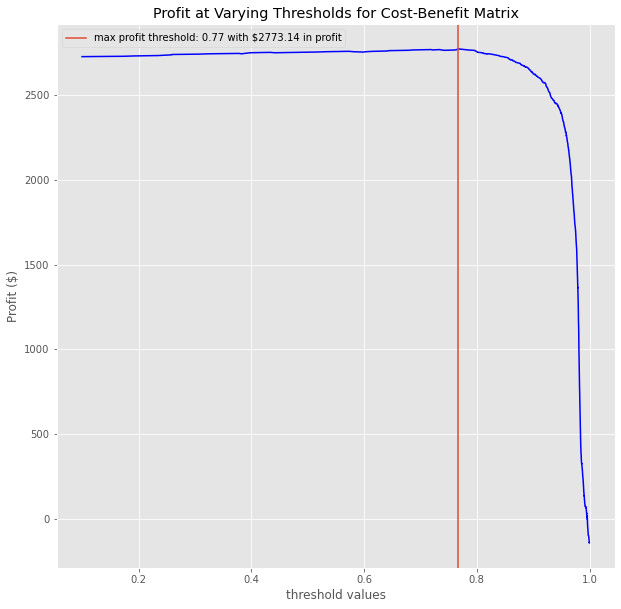

In [375]:
max_profit = np.max(np.array(profits))
max_profit_thresh = thresholds[np.argmax(np.array(profits))]
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(thresholds, profits, color='blue')
ax.set_xlabel('threshold values')
ax.set_ylabel('Profit ($)')
ax.axvline(max_profit_thresh, label=f'max profit threshold: {round(max_profit_thresh,2)} with ${round(max_profit, 2)} in profit')
ax.set_title('Profit at Varying Thresholds for Cost-Benefit Matrix')
ax.legend()

In [376]:
# Use threshold from Profit Curve to determine classification
final_preds = []
for i in sgd_probs: 
#     threshold location at highest profit value
    if i >=max_profit_thresh: 
        final_preds.append(1)
    else: 
        final_preds.append(0)
        
# Threshold max
thres_max = pd.DataFrame(data=[accuracy_score(y_test, final_preds), recall_score(y_test, final_preds),
                   precision_score(y_test, final_preds), roc_auc_score(y_test, final_preds), 
                   f1_score(y_test, final_preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])
# Threshold 50%
baseline= pd.DataFrame(data=[accuracy_score(y_test, sgd_preds), recall_score(y_test, sgd_preds),
                   precision_score(y_test, sgd_preds), roc_auc_score(y_test, sgd_preds), 
                   f1_score(y_test, sgd_preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])


baseline['new thresh'] = thres_max[0]

boa_dict['Approval Threshold'] = max_profit_thresh
boa_dict['Certainty of Prediction'] = f1_score(y_test, final_preds)

baseline

,0,new thresh
accuracy,0.968254,0.968671
recall,0.999401,0.993083
precision,0.968404,0.974627
roc_auc_score,0.645320,0.715563
f1 score,0.983658,0.983768


In [377]:
wells_dict['Certainty of Prediction'] = f1_score(y_test, final_preds)
%store wells_dict

with open('wells_dict.pkl', 'wb') as f: 
    pickle.dump(wells_dict, f)
with open('wells_preds.pkl', 'wb') as f:
    pickle.dump(sgd_probs, f)

Stored 'wells_dict' (dict)


# MVP - other algorithms tried
### Logistic Regression
* Training on entire dataset ~30 minutes, with similar ROC-AUC scores

In [47]:
# 8:34
lr_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(solver='liblinear'))])
lr_grid_params = {}
lr_grid = GridSearchCV(lr_pipe, lr_grid_params, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
fitted = lr_grid.fit(X_train_sub, y_train_sub)
print(f'Logistic Regression ROC-AUC training subset: { lr_grid.score(X_train_sub, y_train_sub)}')
print(f'Logistic Regression ROC-AUC test subset: { lr_grid.score(X_test_sub, y_test_sub)}')

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

ValueError: could not convert string to float: '5-24'

In [104]:
# Creating a ROC Curve

# predict probabilities
lr_probs = fitted.predict_proba(X_test_sub)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
lr_auc = roc_auc_score(y_test_sub, lr_probs)

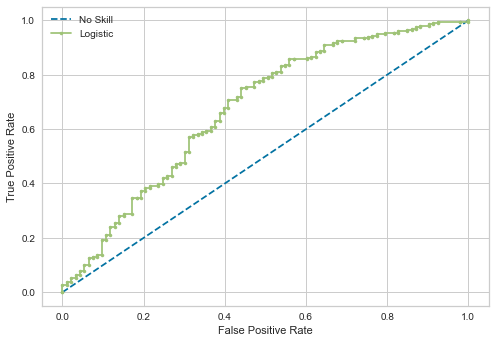

In [106]:
# roc curve for logistic regression model
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test_sub, lr_probs)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

In [182]:
lr_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(solver='saga'))])
lr_grid_params = {'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none']}
lr_grid = GridSearchCV(lr_pipe, lr_grid_params, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
fitted = lr_grid.fit(X_train_sub, y_train_sub)
print(f'Logistic Regression ROC-AUC training subset: { lr_grid.score(X_train_sub, y_train_sub)}')
print(f'Logistic Regression ROC-AUC test subset: { lr_grid.score(X_test_sub, y_test_sub)}')


/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

Logistic Regression ROC-AUC training subset: 0.9088408644400786
Logistic Regression ROC-AUC test subset: 0.9086614173228347


/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [140]:
accuracy_score(fitted.predict(X_test_sub), y_test_sub)

0.8336314847942755

In [137]:
# create an array of predicted probabilities, keeping only the positive outcomes
lr_probs = fitted.predict_proba(X_test_sub)

# Predicted values based on fitted regression model
lr_pred = fitted.predict(X_test_sub)
np.unique(lr_pred)

array([0, 1])

### Random Forest

In [48]:
rf_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())])
rf_grid_params = {}
rf_grid = GridSearchCV(rf_pipe, rf_grid_params, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
fitted = rf_grid.fit(X_train_sub, y_train_sub) 
print(f'Random Forest ROC-AUC training subset: { fitted.score(X_train_sub, y_train_sub)}')
print(f'Random Forest ROC-AUC test subset: { fitted.score(X_test_sub, y_test_sub)}')

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

ValueError: could not convert string to float: '5-24'

In [29]:
## Tuning Random Forest
# Random Forest is overfitting. Increased the num for min_samples_split to 6

rf_pipe2 = Pipeline([('classifier', RandomForestClassifier(max_depth=12, max_features = 6, min_samples_leaf = 60, 
                                                           min_samples_split = 6, n_jobs=-1, n_estimators = 250,
                                                           oob_score=True, random_state=42))])

rf_grid_params2 = {}

rf_grid2 = GridSearchCV(rf_pipe2, rf_grid_params2, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
rf_fitted2 = rf_grid2.fit(X_train_sub, y_train_sub) 
print(f'Random Forest ROC-AUC training subset: { rf_grid2.score(X_train_sub, y_train_sub)}')
print(f'Random Forest ROC-AUC test subset: { rf_grid2.score(X_test_sub, y_test_sub)}')

Random Forest ROC-AUC training subset: 0.9072043852779953
Random Forest ROC-AUC test subset: 0.9068128425998434


In [193]:
accuracy_score(rf_fitted2.predict(X_test_sub), y_test_sub)

0.829512893982808

In [30]:
rf_pred = rf_fitted2.predict(X_test_sub)

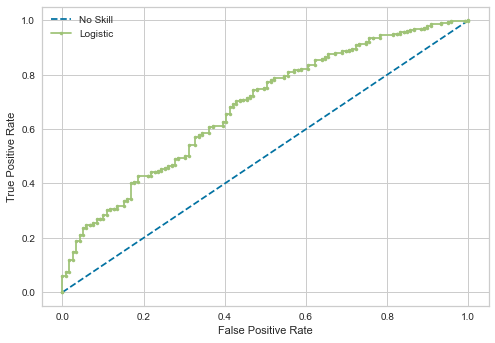

In [175]:
lr_probs = rf_fitted2.predict_proba(X_test_sub)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
lr_auc = roc_auc_score(y_test_sub, lr_probs)
# roc curve for logistic regression model
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test_sub, lr_probs)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

In [110]:
tn, fp, fn, tp = confusion_matrix(y_test_sub, rf_pred)

array([[  0, 119],
       [  0, 579]])

In [208]:
(tn, fp, fn, tp)

(0, 119, 0, 579)

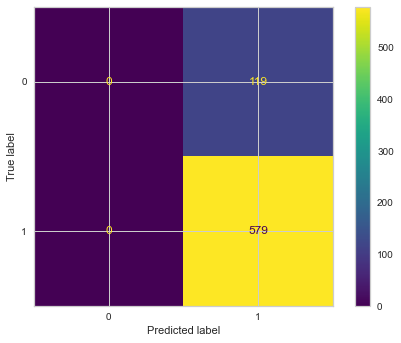

In [210]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf_fitted2, X_test_sub, y_test_sub)

# Class Imbalance - Random Undersampling
* RUS generated a model that predicts both classes rather than just the positive class. However, the threshold appears to be off, so I've created a profit curve to determine the best threshold to use in this business case. 
* Profit Curve shows that profit levels off at a threshold of ~0.80

In [41]:
undersample = RandomUnderSampler(sampling_strategy=0.7)
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)

X_under.shape

(56882, 51)

In [35]:
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_under, y_under, test_size = 0.20, 
                                                                    shuffle=True)

In [38]:
# Train and evaluate a model using undersampled data
rf_pipe_under = Pipeline([('classifier', RandomForestClassifier(max_depth=12, max_features = 6, min_samples_leaf = 60, 
                                                           min_samples_split = 6, n_jobs=-1, n_estimators = 250,
                                                           oob_score=True, random_state=42))])

rf_grid_params_under = {}

rf_grid_under = GridSearchCV(rf_pipe_under, rf_grid_params_under, 
                             cv=StratifiedKFold(10, shuffle=True), scoring = 'roc_auc')
rf_fitted_under = rf_grid2.fit(X_train_u, y_train_u) 
rf_pred_under = rf_fitted_under.predict(X_test_u)
print(f'Random Forest F1 training subset: { rf_grid2.score(X_train_u, y_train_u)}')
print(f'Random Forest F1 test subset: { rf_grid2.score(X_test_u, y_test_u)}')

Random Forest F1 training subset: 0.7822210819998077
Random Forest F1 test subset: 0.7747909967845659


In [55]:
rf_probs_u = rf_fitted_under.predict_proba(X_test_u)

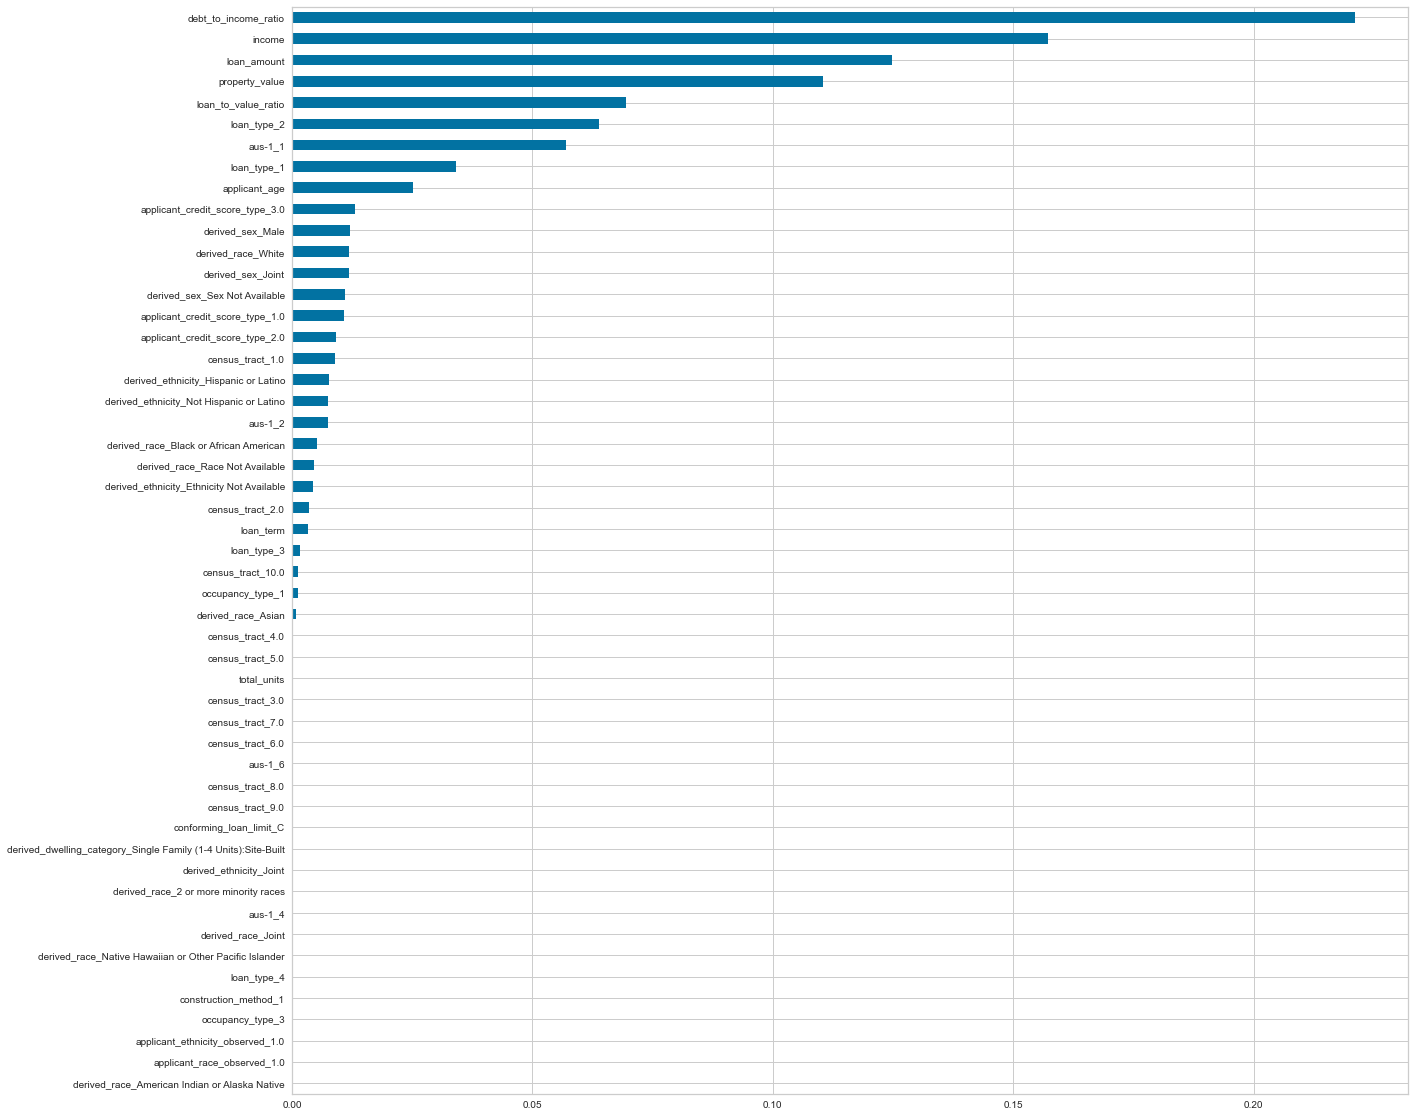

In [188]:
feat_import = rf_fitted2.best_estimator_.named_steps['classifier'].feature_importances_
feature_importance = pd.Series(feat_import, index= X_train_sub.columns)
feature_importance.sort_values(inplace = True)
feature_importance.plot(kind = 'barh', figsize=(20,20))

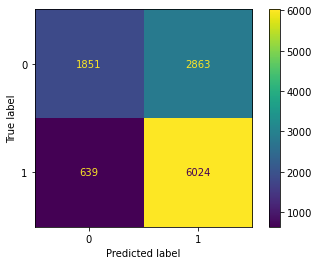

In [39]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf_fitted_under, X_test_u, y_test_u)

In [40]:
from matplotlib import pyplot
rf_probs_u = rf_fitted2.predict_proba(X_test_u)

# keep probabilities for the positive outcome only
rf_probs_u = lr_probs_u[:, 1]

# calculate scores
rf_auc = roc_auc_score(y_test_u, lr_probs_u)
# roc curve for logistic regression model
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test_u, rf_probs_u)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

In [52]:
accuracy_score(y_test_u, rf_pred_under)

0.6921859892766107

# Tuning Logistic Regression

In [185]:
lr_pipe_u = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(max_iter=5000))])
lr_grid_params_u = {'classifier__penalty' : ['l2', 'elasticnet'], 'classifier__C' : np.logspace(-4, 4, 20),
                        'classifier__solver' : ['liblinear', 'saga']}
lr_grid_u = GridSearchCV(lr_pipe_u, lr_grid_params_u, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
lr_fitted_u = lr_grid_u.fit(X_train_sub, y_train_sub)
print(f'Logistic Regression ROC-AUC training subset: { lr_grid.score(X_train_sub, y_train_sub)}')
print(f'Logistic Regression ROC-AUC test subset: { lr_grid.score(X_test_sub, y_test_sub)}')



/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

KeyboardInterrupt: 

# Stochastic Gradient Descent Classifier - ran almost instantaneously
* Parameter Tuning:
    * will use either log or modified-huber for the loss function as these support probabilistic estimates


In [221]:
# Baseline Model
# compare full dataset vs RUS
sgd_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier(loss='log'))])
fitted = sgd_pipe.fit(X_train, y_train)
sgd_preds = fitted.predict(X_test)

In [223]:
pd.DataFrame(data=[accuracy_score(y_test, sgd_preds), recall_score(y_test, sgd_preds),
                   precision_score(y_test, sgd_preds), roc_auc_score(y_test, sgd_preds), 
                   f1_score(y_test, sgd_preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])

,0
accuracy,0.835740
recall,0.999182
precision,0.835608
roc_auc_score,0.512294
f1 score,0.910104


In [231]:
# Parameter Tuning

sgd_pipe2 = Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier())])
sgd_grid_params2 = {'classifier__alpha': 10.0**-np.arange(1,7), 
                   'classifier__loss': ['log'], 
                  'classifier__penalty': ['l2', 'l1', 'elasticnet']}
sgd_grid2 = GridSearchCV(sgd_pipe2, sgd_grid_params2, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
sgd_fitted2 = sgd_grid2.fit(X_train, y_train)
sgd_preds2 = sgd_fitted2.predict(X_test)



In [232]:
pd.DataFrame(data=[accuracy_score(y_test, sgd_preds2), recall_score(y_test, sgd_preds2),
                   precision_score(y_test, sgd_preds2), roc_auc_score(y_test, sgd_preds2), 
                   f1_score(y_test, sgd_preds2)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])

,0
accuracy,0.833303
recall,0.998622
precision,0.833879
roc_auc_score,0.506143
f1 score,0.908845


In [233]:
# Baseline Model: RUS
sgd_pipe_u = Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier(loss='log'))])
fitted_u = sgd_pipe.fit(X_train_u, y_train_u)
sgd_preds_u = fitted.predict(X_test_u)

In [234]:
pd.DataFrame(data=[accuracy_score(y_test_u, sgd_preds_u), recall_score(y_test_u, sgd_preds_u),
                   precision_score(y_test_u, sgd_preds_u), roc_auc_score(y_test_u, sgd_preds_u), 
                   f1_score(y_test_u, sgd_preds_u)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])

,0
accuracy,0.626000
recall,0.789134
precision,0.648495
roc_auc_score,0.592276
f1 score,0.711936


In [235]:
# Parameter Tuning: RUS sample

sgd_pipe2_u = Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier())])
sgd_grid_params2_u = {'classifier__alpha': 10.0**-np.arange(1,7), 
                   'classifier__loss': ['log'], 
                  'classifier__penalty': ['l2', 'l1', 'elasticnet']}
sgd_grid2_u = GridSearchCV(sgd_pipe2_u, sgd_grid_params2_u, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
sgd_fitted2_u = sgd_grid2.fit(X_train_u, y_train_u)
sgd_preds2_u = sgd_fitted2.predict(X_test_u)


In [236]:
pd.DataFrame(data=[accuracy_score(y_test_u, sgd_preds_u), recall_score(y_test_u, sgd_preds_u),
                   precision_score(y_test_u, sgd_preds_u), roc_auc_score(y_test_u, sgd_preds_u), 
                   f1_score(y_test_u, sgd_preds_u)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1 score"])

,0
accuracy,0.626000
recall,0.789134
precision,0.648495
roc_auc_score,0.592276
f1 score,0.711936
